In [2]:
# Aca resolvemos una ODE con condición inicial
# Problema 2 del articulo
# Artificial Neural Networks for Solving Ordinary and Partial Differential Equations

importamos los paquetes necesarios para el entrenamiento

In [3]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Donovan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Se resuelve la ecuación diferencial 

\begin{align}
\nabla^2 \psi(x,y) = e^{-x}(x - 2 + y^3 + 6y)
\end{align}

definición de la arquitectura de la red neuronal

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Model, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        ])
        for _ in range(num_hidden_layers):
            self.layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.Sigmoid()
            ])
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

input_size = 2
hidden_size = 64
output_size = 1
num_hidden_layers = 10

N = Model(input_size, hidden_size, output_size, num_hidden_layers)

### Red de prueba

In [5]:
A = lambda x, y: ((1 - x)*y**3 + x*(1 + y**3)*torch.exp(torch.tensor(-1.0)) 
                  + (1 - y)*x*(torch.exp(-x) - torch.exp(torch.tensor(-1.0)))
                  + y*((1 + x)*torch.exp(-x) - (1 - x + 2*x*torch.exp(torch.tensor(-1.0)))))


Psi_estimate = lambda x, y: A(x,y) + x*(1 - x)*y*(1-y)*N(torch.stack((x,y), dim=1))


In [6]:
# ahora definimos la función f(.)
f = lambda x, y: torch.exp(-x)*(x - 2 + y**3 + 6*y)

In [7]:
def loss(x, y):
    x.requires_grad = True
    y.requires_grad = True
    outputs = Psi_estimate(x, y)
    dPsi_x, dPsi_y = torch.autograd.grad(outputs, (x, y), grad_outputs=torch.ones_like(outputs), create_graph=True)
    d2Psi_x = torch.autograd.grad(dPsi_x, x, grad_outputs=torch.ones_like(dPsi_x), create_graph=True)[0]
    d2Psi_y = torch.autograd.grad(dPsi_y, y, grad_outputs=torch.ones_like(dPsi_y), create_graph=True)[0]
    return torch.mean((d2Psi_x + d2Psi_y - f(x, y))**2)


In [8]:
optimizer = torch.optim.LBFGS(N.parameters())

In [9]:
x = torch.linspace(0, 1, 10)
y = torch.linspace(0, 1, 10)


In [10]:
def closure():
    optimizer.zero_grad()
    l = loss(x, y)
    l.backward()
    return l

for i in range(10):
    optimizer.step(closure)

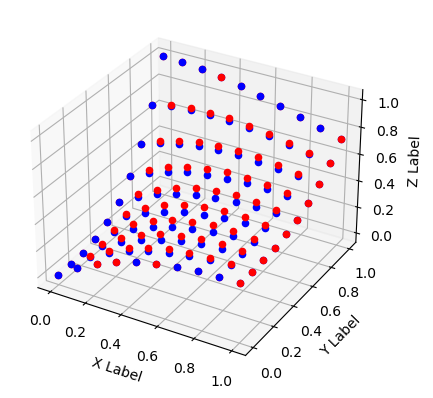

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y1 = torch.linspace(0, 1, 10)
x1 = torch.linspace(0, 1, 10)

# plot with scatter
for i in range(10):
    for j in range(10):
        xx1 = x1[i].reshape(1)
        yy1 = y1[j].reshape(1)
        y_est = Psi_estimate(xx1, yy1).item()
        y_exact = np.exp(-xx1)*(xx1 + yy1**3)
        ax.scatter(xx1, yy1, Psi_estimate(xx1, yy1).item(), c='r', marker='o')
        ax.scatter(xx1, yy1, y_exact, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Comparación de resultados

c:\Users\Donovan\anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


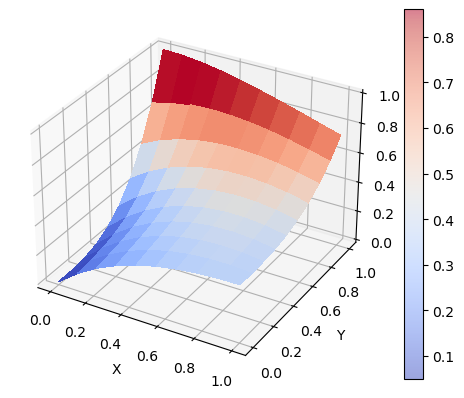

In [12]:
xx = np.linspace(0, 1, 10)
yy = np.linspace(0, 1, 10)

XX, YY = np.meshgrid(xx, yy)
yt = np.exp(-XX)*(XX + YY**3)

xx_torch = torch.linspace(0, 1, 10)
yy_torch = torch.linspace(0, 1, 10)

XX_torch, YY_torch = torch.meshgrid(xx_torch, yy_torch)

psi_estimates = np.zeros((len(xx), len(yy)))

# iterar a través de la malla y evaluar el modelo en cada punto
for i in range(len(xx)):
    for j in range(len(yy)):
        xx1 = xx_torch[i].reshape(1)
        yy1 = yy_torch[j].reshape(1)
        psi_estimates[i,j] = Psi_estimate(xx1, yy1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XX_torch, YY_torch, psi_estimates, cmap='coolwarm', linewidth=0, antialiased=False)
surf = ax.plot_surface(XX, YY, yt, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.colorbar(surf)